# Gradient boosting
Gradient boosting is a widely used machine learning technique that is based on a combination of boosting and gradient descent.

**Boosting** is an ensemble method that combines multiple weak learners (or base learners) to create a strong predictive model. The base models are trained sequentially, where each model focuses on correcting the errors made by the previous models.

In **gradient boosting**, each base model is trained to predict the negative gradients of the loss function with respect to the predictions of the previous models. As a result, adding the newly trained base learner to the ensemble makes a step in the steepest descent direction towards the minimum of the loss.

When the weak learners are decision trees, the resulting method is known as **gradient-boosted decision trees (GBDT)** or **gradient boosting machine (GBM).**

The basic idea of gradient boosting is to build an ensemble of weak models, where each model is trained to predict the residuals of the previous model. This process can be described as follows:

1. Fit a base model $h_1(x)$ to the given labels $y$.
2. Set the initial ensemble to $F_1(x) = h_1(x)$.
3. Fit a base model $h_2(x)$ to the residuals $y - F_1(x)$.
4. Combine the two models into a new ensemble: $F_2(x) = h_1(x) + h_2(x)$. The predictions of $F_2(x)$ should be closer to the targets than $F_1(x)$.
5. Fit a base model $h_3(x)$ to the residuals $y - F_2(x)$.
6. Combine the three models into a new ensemble: $F_3(x) = h_1(x) + h_2(x) + h_3(x)$. The predictions of $F_3(x)$ should be closer to the targets than $F_2(x)$.
7. Continue this process for $M$ steps.
8. Return $F_m(x)$ as the final hypothesis.

We can demonstrate this process in Python by manually building a sequence of regression trees, where each tree is trained to predict the residuals of the previous trees.

In [1]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

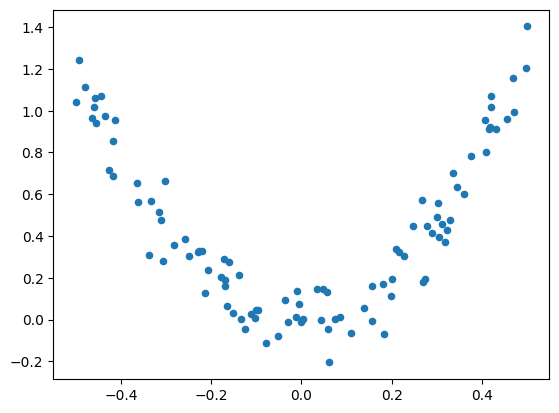

In [2]:
n_samples = 100
X = np.random.rand(n_samples, 1) - 0.5
y = 5 * X[:, 0] ** 2 + 0.1 * np.random.randn(n_samples)

plt.scatter(X, y, s=20)

Our base learners will be decision trees with maximum depth of 2. The first decision tree $h_1$ is fit to the given data set:

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

h1 = DecisionTreeRegressor(max_depth=2)
h1.fit(X, y)

F1 = [h1]  # ensemble of one tree
F1_pred = h1.predict(X)
print(f'R2 score of F1: {r2_score(y, F1_pred):.4f}')

R2 score of F1: 0.7443


The second tree $h_2$ is fitted to the residual errors made by the first tree:

In [4]:
h2 = DecisionTreeRegressor(max_depth=2)
y2 = y - F1_pred
h2.fit(X, y2)

F2 = [h1, h2] # ensemble of two trees
F2_pred = sum(h.predict(X) for h in F2)
print(f'R2 score of F2: {r2_score(y, F2_pred):.4f}')

R2 score of F2: 0.8876


Lastly, a third tree $h_3$ is fitted to the residuals of the second ensemble $F_2$, and then added to the ensemble:

In [5]:
h3 = DecisionTreeRegressor(max_depth=2)
y3 = y - F2_pred
h3.fit(X, y3)

F3 = [h1, h2, h3] # ensemble of three trees
F3_pred = sum(h.predict(X) for h in F3)
print(f'R2 score of F3: {r2_score(y, F3_pred):.4f}')

R2 score of F3: 0.9246


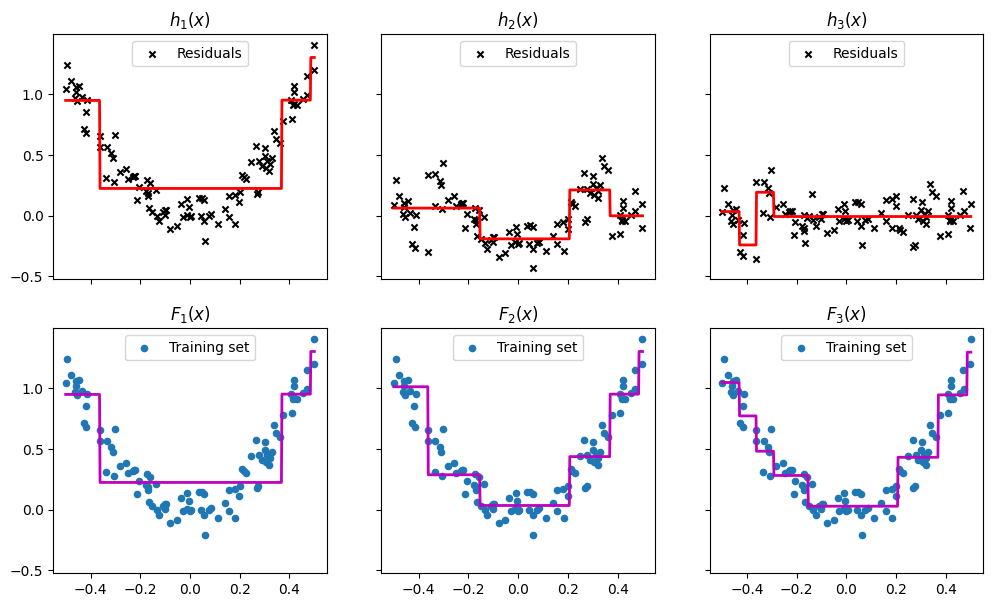

In [6]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 7))
X_test = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)

for i, h, residuals in zip([0, 1, 2], [h1, h2, h3], [y, y2, y3]):
    ax = axes[0, i]
    y_test_pred = h.predict(X_test)
    ax.scatter(X, residuals, c='k', s=20, marker='x', label='Residuals')
    ax.plot(X_test, y_test_pred, 'r', linewidth=2)
    ax.set_title(f'$h_{i + 1}(x)$')
    ax.legend(loc='upper center')

for i, ensemble in enumerate([F1, F2, F3]):
    ax = axes[1, i]
    y_test_pred = sum(h.predict(X_test) for h in ensemble)
    ax.scatter(X, y, s=20, label='Training set')
    ax.plot(X_test, y_test_pred, 'm', linewidth=2)
    ax.set_title(f'$F_{i + 1}(x)$')
    ax.legend(loc='upper center')

## Gradient Boosting in Scikit-Learn
Scikit-Learn provides the following classes that implement the gradient-boosted decision trees (GBDT) model:

- **GradientBoostingClassifier** is used for classification problems.
- **GradientBoostingRegressor** is used for regression problems.

In [7]:
from sklearn.datasets import load_iris
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [8]:
iris = load_iris()
X = iris.data[:, :2] # we only take the first two features
y = iris.target

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [10]:
clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [11]:
print(f'Train accuracy: {clf.score(X_train, y_train):.4f}')
print(f'Test accuracy: {clf.score(X_test, y_test):.4f}')

Train accuracy: 0.9554
Test accuracy: 0.7895


In [12]:
params = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': np.arange(3, 11),
    'subsample': np.arange(0.5, 1.0, 0.1),
    'max_features': ['sqrt', 'log2', None]    
}

search = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), params, n_iter=50, cv=3, n_jobs=-1)
search.fit(X_train, y_train)

print(search.best_params_)

{'subsample': 0.7, 'n_estimators': 10, 'max_features': 'log2', 'max_depth': 4}


In [13]:
best_clf = search.best_estimator_
print(f'Train accuracy: {best_clf.score(X_train, y_train):.4f}')
print(f'Test accuracy: {best_clf.score(X_test, y_test):.4f}')

Train accuracy: 0.8929
Test accuracy: 0.7895


In [14]:
def plot_decision_boundaries(clf, X, y, feature_names, class_names, 
                             colors=['r', 'b', 'g'], markers=('s', 'o', '^')):  
    cmap = ListedColormap(colors)
      
    # create a mesh of n sample points in the range [x1_min, x1_max] x [x2_min, x2_max]
    n = 1000 
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1 
    x1, x2 = np.meshgrid(np.linspace(x1_min, x1_max, n), np.linspace(x2_min, x2_max, n))
    
    # find the label of each point in the mesh
    y_pred = clf.predict(np.c_[x1.ravel(), x2.ravel()])
    y_pred = y_pred.reshape(x1.shape) 
    
    # put the result into a color plot  
    plt.contourf(x1, x2, y_pred, cmap=cmap, alpha=0.4)
    
    # plot the points from the data set
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=class_names[y], style=class_names[y], 
                    palette=colors, markers=markers, edgecolor='k')
    
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.legend()

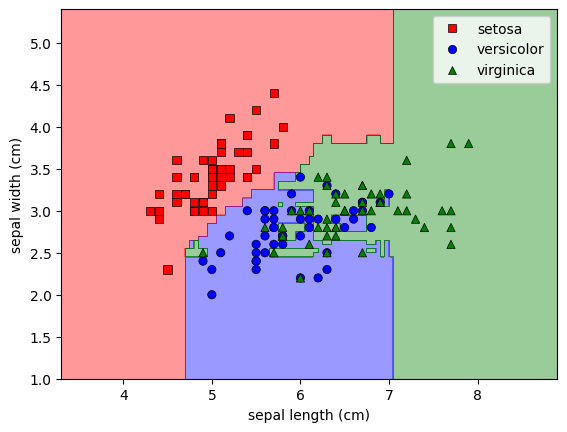

In [15]:
plot_decision_boundaries(best_clf, X, y, iris.feature_names, iris.target_names)

## GradientBoostingRegressor
For demonstrating the gradient boosting regressor, we will use the California housing data set. The goal in this data set is to predict the median house value of a given district (house block) in California, based on 8 different features of that district (such as the median income or the average number of rooms per household).

In [16]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor

In [17]:
data = fetch_california_housing()
X, y = data.data, data.target
feature_names = data.feature_names

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [19]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

In [20]:
train_score = reg.score(X_train, y_train)
print(f'R2 score (train): {train_score:.4f}')

test_score = reg.score(X_test, y_test)
print(f'R2 score (test): {test_score:.4f}')

R2 score (train): 0.8027
R2 score (test): 0.7774


In [22]:
params = {
    'n_estimators': [10, 50, 100],
    'max_depth': np.arange(3, 11),
    'subsample': np.arange(0.5, 1.0, 0.1),
    'max_features': ['sqrt', 'log2', None]    
}

search = RandomizedSearchCV(GradientBoostingRegressor(random_state=0), params, n_iter=50, cv=3, n_jobs=-1)
search.fit(X_train, y_train)

print(search.best_params_)

{'subsample': 0.7999999999999999, 'n_estimators': 100, 'max_features': 'log2', 'max_depth': 7}


In [23]:
best_reg = search.best_estimator_
print(f'R2 score (train): {best_reg.score(X_train, y_train):.4f}')
print(f'R2 score (test): {best_reg.score(X_test, y_test):.4f}')

R2 score (train): 0.9182
R2 score (test): 0.8355


### The Learning Curve
We can also plot the training and test errors in every boosting iteration. The training errors are stored in the `train_score_` attribute of the estimator. The test errors can be obtained by calling the `staged_predict()` method, which returns a generator that yields the model predictions on a given data set at each iteration.

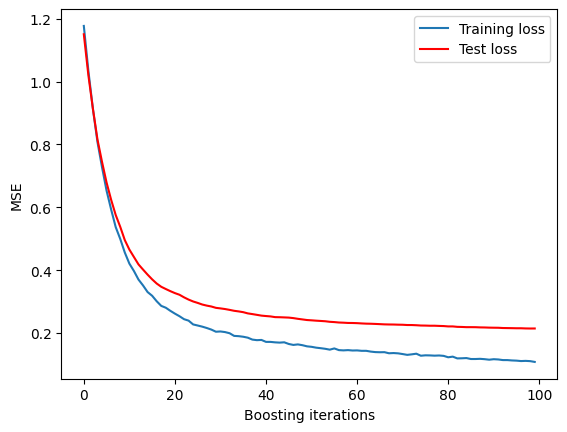

In [24]:
from sklearn.metrics import mean_squared_error as MSE

test_score = np.zeros(best_reg.n_estimators_)
for i, y_test_pred in enumerate(best_reg.staged_predict(X_test)):
    test_score[i] = MSE(y_test, y_test_pred)
    
plt.plot(np.arange(best_reg.n_estimators), best_reg.train_score_, label='Training loss')
plt.plot(np.arange(best_reg.n_estimators), test_score, 'r', label='Test loss')

plt.xlabel('Boosting iterations')
plt.ylabel('MSE')
plt.legend()

In [26]:
params = {    
    'max_depth': np.arange(3, 11),
    'subsample': np.arange(0.5, 1.0, 0.1),
    'max_features': ['sqrt', 'log2', None]    
}

search = RandomizedSearchCV(GradientBoostingRegressor(random_state=0, n_estimators=100, n_iter_no_change=5), 
                            params, n_iter=50, cv=3, n_jobs=-1)
search.fit(X_train, y_train)

print(search.best_params_)

reg = search.best_estimator_
print(f'R2 score (train): {reg.score(X_train, y_train):.4f}')
print(f'R2 score (test): {reg.score(X_test, y_test):.4f}')

{'subsample': 0.8999999999999999, 'max_features': 'sqrt', 'max_depth': 9}
R2 score (train): 0.9523
R2 score (test): 0.8312
